#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9044125416373000940
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 177141232924792071
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   1%|1         | 2/148 [00:00<00:08, 17.39it/s]

r_index: 100%|##########| 91/91 [00:00<00:00, 476.33it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(869, 15)
(1221, 15)
(1098, 15)


StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [19]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

MinMaxScaler

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [21]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(695, 15)
(976, 15)
(878, 15)


#### 10-Fold Crossvalidation

In [22]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [23]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [24]:
from sklearn.model_selection import cross_val_score

def objectiveGB(trial: Trial, X_train, y_train) -> float:
    gb_paramas = {
        "random_state": 42,
        "learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    gb = GradientBoostingRegressor(**gb_paramas)
    r2 = cross_val_score(gb, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [25]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:14:26,039] A new study created in memory with name: gb_parameter_opt
[I 2023-08-17 22:14:26,532] Trial 0 finished with value: 0.3130793856389086 and parameters: {'n_estimators': 198, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 4, 'subsample': 0.10235248038612035}. Best is trial 0 with value: 0.3130793856389086.
[I 2023-08-17 22:14:27,499] Trial 1 finished with value: 0.48179919241799396 and parameters: {'n_estimators': 128, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 4, 'subsample': 0.4514862061688566}. Best is trial 1 with value: 0.48179919241799396.
[I 2023-08-17 22:14:27,761] Trial 2 finished with value: 0.43782353462605245 and parameters: {'n_estimators': 118, 'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 10, 'subsample': 0.13638140982253597}. Best is trial 1 with value: 0.48179919241799396.
[I 2023-08-17 22:14:28,482] Trial 3 finished with value: 0.4134892356612682 and parameters: {'n_estimators': 183, 'max_depth': 

Best r2:  0.5146052690060026
Best trial: {'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 7, 'min_samples_split': 6, 'subsample': 0.41460654686962134}


In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_param_importances(study)

In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 7, 'min_samples_split': 6, 'subsample': 0.41460654686962134}


In [30]:
study.best_trial.params["n_estimators"]

150

In [31]:
gb_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    "subsample": study.best_trial.params["subsample"]
}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(As_X_train, As_y_train)

GradientBoostingRegressor(max_depth=19, min_samples_leaf=7, min_samples_split=6,
                          n_estimators=150, random_state=42,
                          subsample=0.41460654686962134)

In [32]:
# gb_params = {
#     "random_state": 42,
#     "learning_rate": 0.1,
#     "n_estimators": 100,
#     "max_depth": 2,
#     "min_samples_leaf": 8,
#     "min_samples_split": 2,
#     "subsample": 0.35775273871202684
# }

# gb = GradientBoostingRegressor(**gb_params)
# gb.fit(As_X_train, As_y_train)

In [33]:
y_train_pred = gb.predict(As_X_train)
y_test_pred = gb.predict(As_X_test)

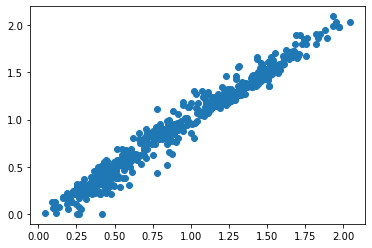

In [34]:
plt.scatter(y_train_pred, np.array(As_y_train))

In [35]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.08183464850632197
Test RMSE:  0.36462016270666164


In [36]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9711300021590777
Test R2:  0.47391237773537676


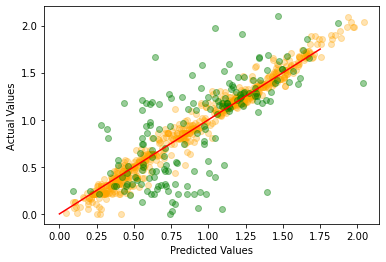

In [37]:
import matplotlib.pyplot as plt

plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add trendline
# z = np.polyfit(y_train_pred, As_y_train, 1)
# p = np.poly1d(z)
# plt.plot(y_train_pred, p(y_train_pred), color='red', linestyle='-')

# Add y=x line
plt.plot([0, 1.75], [0, 1.75], color='red', linestyle='-')

plt.show()

In [38]:
# import shap

# #background = shap.sample(As_X_train, 100)  # Adjust the number of samples as needed

# explainer = shap.KernelExplainer(gb.predict, As_X_train)
# shap_values = explainer.shap_values(As_X_train)

# shap.summary_plot(shap_values, As_X_train)

# shap.force_plot(explainer.expected_value, shap_values[0], As_X_train[0])

# print(shap_values)

Cd

Optimization

In [39]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:15:42,165] A new study created in memory with name: gb_parameter_opt
[I 2023-08-17 22:15:42,963] Trial 0 finished with value: 0.5573331026755531 and parameters: {'n_estimators': 165, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 5, 'subsample': 0.39497761139782495}. Best is trial 0 with value: 0.5573331026755531.
[I 2023-08-17 22:15:44,160] Trial 1 finished with value: 0.5451641288933882 and parameters: {'n_estimators': 168, 'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 5, 'subsample': 0.21927529954984715}. Best is trial 0 with value: 0.5573331026755531.
[I 2023-08-17 22:15:45,481] Trial 2 finished with value: 0.5761498305630923 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 2, 'subsample': 0.4915916186261332}. Best is trial 2 with value: 0.5761498305630923.
[I 2023-08-17 22:15:47,678] Trial 3 finished with value: 0.5847760789965323 and parameters: {'n_estimators': 193, 'max_depth': 11, '

Best r2:  0.6037106484661617
Best trial: {'n_estimators': 126, 'max_depth': 23, 'min_samples_leaf': 5, 'min_samples_split': 10, 'subsample': 0.4929601862393594}


In [40]:
optuna.visualization.plot_parallel_coordinate(study)

In [41]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 126, 'max_depth': 23, 'min_samples_leaf': 5, 'min_samples_split': 10, 'subsample': 0.4929601862393594}


126

In [42]:
gb_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    "subsample": study.best_trial.params["subsample"]
}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(Cd_X_train, Cd_y_train)

GradientBoostingRegressor(max_depth=23, min_samples_leaf=5,
                          min_samples_split=10, n_estimators=126,
                          random_state=42, subsample=0.4929601862393594)

In [43]:
# gb_params = {
#     "random_state": 42,
#     "learning_rate": 0.1,
#     "n_estimators": 138,
#     "max_depth": 2,
#     "min_samples_leaf": 3,
#     "min_samples_split": 6,
#     "subsample": 0.4574655226902498
# }

# gb = GradientBoostingRegressor(**gb_params)
# gb.fit(Cd_X_train, Cd_y_train)

In [44]:
y_train_pred = gb.predict(Cd_X_train)
y_test_pred = gb.predict(Cd_X_test)

In [45]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.008282204061177578
Test RMSE:  0.05070252169182093


In [46]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9901542608084716
Test R2:  0.6673821061560379


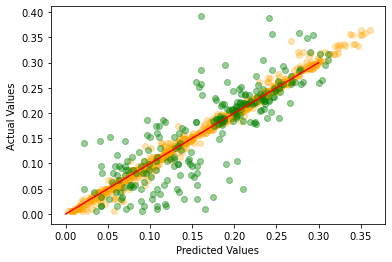

In [47]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.30], [0, 0.30], color='red', linestyle='-')

plt.show()

In [48]:
# explainer = shap.KernelExplainer(gb.predict, Cd_X_train)
# shap_values = explainer.shap_values(Cd_X_train)

# shap.summary_plot(shap_values, Cd_X_train)

# shap.force_plot(explainer.expected_value, shap_values[0], Cd_X_train[0])

# print(shap_values)

Ni

In [49]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:17:43,099] A new study created in memory with name: gb_parameter_opt
[I 2023-08-17 22:17:44,265] Trial 0 finished with value: 0.8151284064435584 and parameters: {'n_estimators': 166, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 6, 'subsample': 0.4652340975380427}. Best is trial 0 with value: 0.8151284064435584.
[I 2023-08-17 22:17:44,947] Trial 1 finished with value: 0.8074838109506505 and parameters: {'n_estimators': 182, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 3, 'subsample': 0.47546715941599227}. Best is trial 0 with value: 0.8151284064435584.
[I 2023-08-17 22:17:45,130] Trial 2 finished with value: 0.5935896601181653 and parameters: {'n_estimators': 107, 'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 3, 'subsample': 0.19446926522479863}. Best is trial 0 with value: 0.8151284064435584.
[I 2023-08-17 22:17:46,468] Trial 3 finished with value: 0.7985950513835388 and parameters: {'n_estimators': 179, 'max_depth': 16, 'm

Best r2:  0.8319038495852193
Best trial: {'n_estimators': 162, 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 3, 'subsample': 0.49005718087777245}


In [50]:
optuna.visualization.plot_parallel_coordinate(study)

In [51]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 162, 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 3, 'subsample': 0.49005718087777245}


162

In [52]:
gb_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    "subsample": study.best_trial.params["subsample"]
}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(Ni_X_train, Ni_y_train)

GradientBoostingRegressor(max_depth=20, min_samples_leaf=8, min_samples_split=3,
                          n_estimators=162, random_state=42,
                          subsample=0.49005718087777245)

In [53]:
# gb_params = {
#     "random_state": 42,
#     "learning_rate": 0.1,
#     "n_estimators": 181,
#     "max_depth": 28,
#     "min_samples_leaf": 7,
#     "min_samples_split": 7,
#     "subsample": 0.4946447123833718
# }

# gb = GradientBoostingRegressor(**gb_params)
# gb.fit(Ni_X_train, Ni_y_train)

In [54]:
y_train_pred = gb.predict(Ni_X_train)
y_test_pred = gb.predict(Ni_X_test)

In [55]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.11719331807385495
Test RMSE:  0.4407756274021183


In [56]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9908393420370447
Test R2:  0.8477238696835727


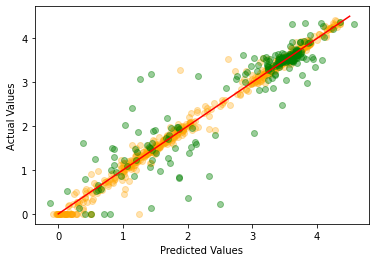

In [57]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto")
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add trendline
# z = np.polyfit(y_train_pred, As_y_train, 1)
# p = np.poly1d(z)
# plt.plot(y_train_pred, p(y_train_pred), color='red', linestyle='-')

# Add y=x line
plt.plot([0, 4.5], [0, 4.5], color='red', linestyle='-')

plt.show()